# Advanced usage of HiPS and MOCs to explore complex regions of interest

Stefania Amodea¹, Matthieu Baumann¹, Thomas Boch¹, Caroline Bot¹, Katarina A. Lutz¹.

1. Université de Strasbourg, CNRS, Observatoire Astronomique de Strasbourg, UMR 7550, F-67000, Strasbourg, France

Thomas Boch and Caroline Bot wrote the original version of this tutorial, available on the [EURO-VO tutorials page](http://www.euro-vo.org/?q=science/scientific-tutorials). It was presented at the workshop "[Detecting the unexpected, Discovery in the Era of Astronomically Big Data](https://www.lsstcorporation.org/node/107)". The version here is an adaptation to jupyter notebooks by the Strasbourg astronomical Data Center ([CDS](https://cdsweb.u-strasbg.fr/)) team.

*** 

## Introduction

This tutorial demonstrates an advanced usage of Hierarchical Progressive Surveys ([HiPS](https://ui.adsabs.harvard.edu/abs/2017ivoa.spec.0519F/abstract)) and Multi-Order Coverage ([MOC](https://www.ivoa.net/documents/MOC/)) maps. Wis this tutorial, you will: 

1. learn how to find fits files
2. build a map of the coverage of all the fits files 
3. select only the parts of this map that correspond to low-extinction regions
4. retrieve objects from large catalogs inside the obtained map -- that has a non-trivial shape and non-necessarily-connected regions
5. combine catalogs to visualize a color-color diagram

In [1]:
# General python packages
from pathlib import Path
import numpy as np

# For vizualization
import matplotlib.pyplot as plt

# Packages specific to astronomy tasks
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
import astropy.units as u
import mocpy
import cdshealpix
import pyvo
from astroquery.vizier import Vizier

## Step 1: Finding the images

We want to find all Short-Red images in the Macquarie/AAO/Strasbourg Hα Planetary Galactic catalog ([MASH](https://vizier.cfa.harvard.edu/vizier/MASH/index.htx)) using the VizieR associated data service.

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

The [VizieR](https://vizier.cds.unistra.fr/) service at CDS inventories astronomical catalogs published in the literature. Some of these catalogs contain data associated with publications and the tables therein. This data can be browsed and explored through the VizieR-associated data service, linked to the traditional VizieR table service. Here we look for images associated with the MASH catalog of planetary nebulae ([Parker *et. al.* 2006-2008](https://ui.adsabs.harvard.edu/abs/2006yCat.5127....0P/abstract)). The MASH fits files are cut-outs extracted from a larger Hα and Short Red survey to constitute a set of regions of interest around planetary nebulae. 

To find VizieR-associated data, we use the Table Access Protocol (TAP) with the VizieR endpoint. Through the VizieR TAP endpoint, we can search for tables, their content, and information on associated data. 

First, we search for the MASH catalog:

In [2]:
# give the address of the service, you can also directly visit the website
tap_vizier = pyvo.dal.TAPService("https://tapvizier.cds.unistra.fr/TAPVizieR/tap")

# a query that searches for all tables with the words MASH and Parker in their description
query = """
        SELECT  *  FROM tables 
        WHERE description LIKE '%MASH%Parker%'
        """

mash_catalogues = tap_vizier.search(query).to_table()
mash_catalogues

schema_name,table_name,table_type,description,utype,nrows
object,object,object,object,object,object
J_MNRAS,J/MNRAS/412/223/table4,table,"The nine MASH PNe detected and possibly detected in the PMN survey ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",,9
J_MNRAS,J/MNRAS/412/223/table1,table,"MASH PNe detected in the NVSS ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",,201
V_combined,V/127A/mash2,table,"The MASH-II Supplement (from paper II) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",,335
V_combined,V/127A/mash1,table,"The MASH Catalog of Planetary Nebulae (paper I) ( Parker Q.A., Acker A., Frew D.J., Hartley M., Peyaud A.E.J., Phillipps S., Russeil D., Beaulieu S.F., Cohen M., Koppen J., Marcout J., Miszalski B., Morgan D.H., Morris R.A.H., Ochsenbein F., Pierce M.J.,)",,903
J_MNRAS,J/MNRAS/412/223/mpgs2,table,"MASH PNe detected in the MPGS-2 (Cat. VIII/82) ( Bojicic I.S., Parker Q.A., Filipovic M.D., Frew D.J.)",,81


In this tutorial, we are interested in the tables belonging to the catalogs `V/127A`. This includes tables `V/127A/mash1` and `V/127A/mash2`. To have a look at the content of these tables, we do the following:

In [3]:
query = """
        SELECT TOP 5 * FROM \"V/127A/mash1\" 
        """
mash1_head = tap_vizier.search(query).to_table()
mash1_head

recno,n_PNG,PNG,Name,RAJ2000,DEJ2000,GLon,GLat,MajDiam,MinDiam,CS,Morph,Tel,ObsDate,HaExp,HaFld,Comments,img,ImageHa,ImageSr,AssocData
,,,,deg,deg,deg,deg,arcsec,arcsec,,,,'Y:M:D',,,,,,,
int32,str1,object,object,float64,float64,float64,float64,float64,float64,object,object,object,float64,object,object,object,object,object,object,object
29,L,G234.7-02.2,PHR0724-2021,111.05458333333331,-20.36361111111111,234.7045,-2.2774,134.5,54.0,,A,SA,2452672.0,HA18201,HA842,"Large, very faint diffuse arcuate nebula; has [NII]~2xH-alpha, nothing in blue",1029,img_ha,img_sr,fits
2,P,G227.3-12.0,PHR0633-1808,98.35374999999999,-18.13972222222222,227.3207,-12.0289,17.0,15.0,,Ea,SA,2452672.0,HA18191,HA926,"Very faint, partial arcuate nebula also observed M1 060100; [NII]~0.8xH-alpha, strong [SII], only weak H-beta in blue - inconclusive",1002,img_ha,img_sr,fits
16,T,G227.2-03.4,PHR0705-1419,106.41041666666665,-14.318055555555553,227.2852,-3.4029,15.0,15.0,,E,SA,2452668.0,HA18244,HA1017,"Small, circular PN around a faint central star; also observed M1 040100; [NII]~0.7 H-alpha, [OIII]>>H-beta",1016,img_ha,img_sr,fits
5,L,G223.6-06.8,PHR0646-1235,101.60583333333332,-12.598888888888887,223.6338,-6.8035,40.0,37.0,,E,SA,2453788.0,HA18194,HA1016,Slightly oval very faint PN candidate - has [OIII] and H-alpha,1005,img_ha,img_sr,fits
10,P,G224.3-05.5,PHR0652-1240,103.08458333333331,-12.67611111111111,224.3504,-5.5463,187.0,180.0,,I,SA,2452670.0,HA18244,HA1017,"Faint, extended S-shaped emission nebula, possible evolved PN, also observed M1 080100; has [NII]~0.8Ha, [OIII], strong [SII], [OIII]>H-beta",1010,img_ha,img_sr,fits


As you can see, the last column of this table is called `AssocData` and contains the entry `fits`. If you look at this table on the VizieR web interface, you can download the associated fits file. Within this notebook, we query the `obscore` database to get the URLs to the fits file. Using the `astropy.io.fits` module, we can open the fits files from their URLs.

In [4]:
obs_tap_vizier = pyvo.dal.TAPService(
    "https://cdsarc.cds.unistra.fr/saadavizier.tap/tap"
)
query = """
        SELECT TOP 5  *  FROM obscore 
        WHERE obs_collection='V/127A'   
        """
mash_fits = obs_tap_vizier.search(query).to_table()
mash_fits

access_estsize,access_format,access_url,bib_reference,calib_level,dataproduct_type,em_band,em_max,em_min,extension,facility_name,has_wcs,instrument_name,obs_collection,obs_id,obs_publisher_did,oidsaada,o_ucd,pol_states,s_dec,s_fov,s_ra,s_region,s_resolution,target_name,t_exptime,t_max,t_min,t_resolution
kbyte,,,,,,spect,,,meta.code,,meta.code,,,,,,,,deg,deg,deg,,arcsec,,,,,
int64,object,object,object,int32,object,object,float64,float64,int32,object,int32,object,object,object,object,object,object,object,float64,float64,float64,object,float64,object,float64,float64,float64,float64
593280,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410952,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1003_sr.fits,ivo://CDS.VizieR/V/127A?res=1003_sr.fits,864975549779410952,obs.image,NotSet,-1.5865839477767756,0.06691977089279492,98.28859901738655,Polygon ICRS 98.32185416715423 -1.6196983582025153 98.2554911971524 -1.6198194197631401 98.25534493248595 -1.5534690033127159 98.32170577379793 -1.553347946272979,0.9487801044986105,,--,--,51936.0,--
604800,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410956,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1004_sr.fits,ivo://CDS.VizieR/V/127A?res=1004_sr.fits,864975549779410956,obs.image,NotSet,-2.297710371260397,0.06762530618624343,101.26444315811088,Polygon ICRS 101.2976137401653 -2.3308960388799083 101.23123025194138 -2.330873742572581 101.23127411793685 -2.264523934525058 101.29765452165769 -2.264546228680211,0.9487193713839844,,--,--,51523.0,--
610560,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410957,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1035_sr.fits,ivo://CDS.VizieR/V/127A?res=1035_sr.fits,864975549779410957,obs.image,NotSet,-12.991600787995576,0.07137331195213058,111.95416628253616,Polygon ICRS 111.9880275498896 -13.02496499694983 111.91992278271307 -13.024604734749705 111.92031411300253 -12.958232196627087 111.98840068115456 -12.95859235931425,0.9490542200229777,,--,--,51226.0,--
725760,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410958,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1005_ha.fits,ivo://CDS.VizieR/V/127A?res=1005_ha.fits,864975549779410958,obs.image,NotSet,-12.598746823564728,0.06694953201147846,101.60569711358164,Polygon ICRS 101.6401139439526 -12.631495699678862 101.57215630523349 -12.632324847030922 101.57128907631345 -12.56599354794031 101.63922913593451 -12.565164621564891,0.9484730237017694,,--,--,51159.0,--
619200,application/fits,https://cdsarc.cds.unistra.fr/saadavizier/download?oid=864975549779410965,2006MNRAS.373...79P,-1,image,Optical,1e-06,3e-07,--,UKST,5,SuperCOSMOS I,V/127A,1042_sr.fits,ivo://CDS.VizieR/V/127A?res=1042_sr.fits,864975549779410965,obs.image,NotSet,-20.931482717073788,0.0726809333271836,115.09527444468613,Polygon ICRS 115.1309510189908 -20.964521012252085 115.05989349439974 -20.9648025966783 115.0596136062386 -20.89843701281709 115.13063965676528 -20.89815555052344,0.9490108047106889,,--,--,50871.0,--


As you can see, the result from this query provides information on the fits files associated with the MASH catalogs. In particular, the column `access_url` provides the location of the data. To get the first image we could do:

`image = fits.open(mash_fits['access_url'][0])`

and then work on the image, plot it or save it to our machine. However, downloading all the data takes quite some time. For this tutorial, **we prepared a subsample of 335 of these Short Red images that will run promptly** but we encourage you to try accessing the full Short Red sample on your own later. The subsample is available either at http://astro.u-strasbg.fr/~bot/BochBot.tar.gz or in the Data Folder of this repository. If you run this tutorial on Binder, you do not need to download anything. 

## Step 2: Create a MOC of the MASH images

The multi-order coverage (MOC) map of a set of images represents their sky coverage. MOCs can describe arbitrary zones in the sky which do not need to be connected. You'll see that the union or intersection of two MOCs requires few time and computational effort. Catalogs can also be filtered by MOCs. 

Here we want to use the fits files just downloaded to create a MOC map corresponding to the coverage of the MASH images.

### Organising data

In [5]:
# Where to find fits images downloaded from the archive above
datadir = Path("Data/MASH_Sample/")
datadir.mkdir(parents=True, exist_ok=True)
# Make new directory where to save MOCs
outdir = Path("Data/Result_moc/")
outdir.mkdir(parents=True, exist_ok=True)

In most cases, we could ignore the next cell.  However, some possible deprecated keywords in the fits header would hamper the MOC creation and would cause errors in the underlying `astropy.wcs.WCS` module. This is why we rewrite the headers of the fits files so that they only contain the useful keywords needed to define the coordinate frame correctly before using `mocpy`. 

In [6]:
# Get a list of all fits files in datadir
mash_file_list = datadir.glob("*_sr.fits")

# Modify the header so that the MOC creation works smoothly
for file_name in mash_file_list:
    ima = fits.open(file_name)
    hdr = ima[0].header
    needed_keywords = [
        "SIMPLE",
        "BITPIX",
        "NAXIS",
        "EXTEND",  # basic fits keywords
        # essential WCS keywords
        "NAXIS1",
        "NAXIS2",
        "RADECSYS",
        "CD1_1",
        "CD1_2",
        "CD2_1",
        "CD2_2",
        "CTYPE1",
        "CUNIT1",
        "CDELT1",
        "CRPIX1",
        "CRVAL1",
        "CTYPE2",
        "CUNIT2",
        "CDELT2",
        "CRPIX2",
        "CRVAL2",
        # used additionally by mocpy
        "EQUINOX",
        "BLANK",
    ]
    new_hdr = fits.Header()
    for keyword in needed_keywords:
        try:
            new_hdr[keyword] = ima[0].header[keyword]
        except KeyError:
            continue
    new_hdr["RADESYS"] = new_hdr["RADECSYS"]
    fits.writeto(
        outdir / Path(file_name.stem + "_modified.fits"),
        ima[0].data,
        new_hdr,
        output_verify="fix",
        overwrite=True,
    )
    ima.close()

### Create the MOC

Here we can create the MOC of the MASH images with the `MOCPy` module. This can take a few seconds.

In [7]:
# Get a list of the updated files and create the MOC
mash_file_list = outdir.glob("*_sr_modified.fits")
moc_mash = mocpy.MOC.from_fits_images(mash_file_list, max_norder=15)
moc_mash.save(str(outdir / "mash_moc.fits"), overwrite=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Plot the MOC

We'll use the MOCpy `World2ScreenMPL` class.

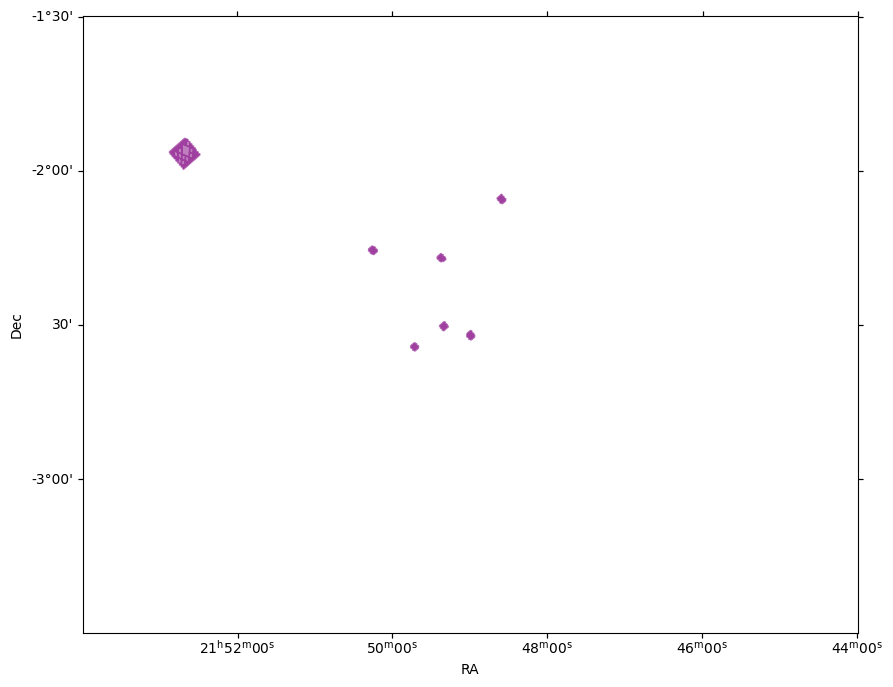

In [8]:
fig_centre = SkyCoord(
    "21:49:00", "-02:30:00", unit=(u.hourangle, u.deg), frame="galactic"
)

fig = plt.figure(figsize=(10, 8))
with mocpy.World2ScreenMPL(
    fig,
    fov=2.5 * u.deg,
    center=fig_centre,
    coordsys="galactic",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    moc_mash.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="purple")
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter("hh:mm:ss")
    lat.set_major_formatter("dd:mm")
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)

This figure only shows a small region on the Sky, but you can see how the MOC has arbitrary shapes and not all regions are connected.

## Step 3: Load an archival extinction map and create the MOC of the low extinction regions

Different works (e.g. [Schlegel et al. 1998](https://iopscience.iop.org/article/10.1086/305772), [Schlafly  & Finkbeiner 2011](https://ui.adsabs.harvard.edu/abs/2011AAS...21831803S/abstract), [Green et al. 2015](https://iopscience.iop.org/article/10.1088/0004-637X/810/1/25)...) have created extinction maps of the sky that are publicly available. Some of these maps are all-sky maps, while others have higher resolutions, or come from different methods... They can be found in HEALPix format (among others) on the Legacy Archive for Microwave Background Data Analysis ([LAMBDA](https://lambda.gsfc.nasa.gov/)) website or on the Analysis Center for Extended Data ([CADE](http://cade.irap.omp.eu/dokuwiki/doku.php?id=start)) website. 

For this tutorial, we will download the well-known all-sky extinction map from Schlegel *et al.* from the LAMBDA  website and define the low extinction area for which $0 < E(B-V) < 0.5$ as a MOC. It has an [information page](https://lambda.gsfc.nasa.gov/product/foreground/fg_sfd_info.html).

The map is available here: https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/lambda_sfd_ebv.fits and we save it to disc. 

In [9]:
ext_map = fits.open(
    "https://lambda.gsfc.nasa.gov/data/foregrounds/SFD/" + "lambda_sfd_ebv.fits"
)
ext_map.writeto(outdir / "Schlegel_extinction_map.fits", overwrite=True)
ext_map.close()

We are only interested in regions with low extinction. So we aim to get a MOC of all regions where the extinction values from the Schlegel *et al.* map are between 0 and 0.5mag. The extinction map we got from the NASA webpage is in the HEALPix format. This is an efficient presentation of all-sky maps. The HEALPix tesselation is also used by MOCs. So to get the MOC from the extinction map, we do the following. 

First, we check the coordinate system in the map header. We will need to convert to equatorial coordinates, change the projection of the map, and set the order (*i.e.* resolution) of the map.

In [10]:
# open the downloaded FITS file
hdul = fits.open(outdir / "Schlegel_extinction_map.fits")
hdr = hdul[0].header
hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   32 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2003-02-05T00:00:00' /file creation date (YYYY-MM-DDThh:mm:ss UT)    
OBJECT  = 'ALL-SKY '           / Portion of sky given                           
COMMENT   This file contains an all-sky Galactic reddening map, E(B-V), based on
COMMENT   the derived reddening maps of Schlegel, Finkbeiner and Davis (1998).  
COMMENT   Software and data files downloaded from their website were used to    
COMMENT   interpolate their high resolution dust maps onto pixel centers        
COMMENT   appropriate for a 

In [11]:
print((hdul[1].data).shape)
hdul[1].data

(3145728,)


FITS_rec([( 9.625492, 1.), (46.090515, 1.), ( 8.18071 , 1.), ...,
          (15.149189, 1.), (14.107367, 1.), (15.463686, 1.)],
         dtype=(numpy.record, [('TEMPERATURE', '>f4'), ('N_OBS', '>f4')]))

The data field here has a specific shape. It contains tuples for which the first value is the extinction (named 'TEMPERATURE') and the second one is the number of observations of the value (you can check that it is `1` everywhere).

In [12]:
extinction_values = hdul[1].data["TEMPERATURE"]

 Let's extract the information about the number of sides and the order of the healpix map from the header of the fits file

In [13]:
nside = hdul[0].header["NSIDE"]
norder = hdul[0].header["RESOLUTN"]

The header allows to see that this map is in galactic coordinates. We will need to convert this into equatorial coordinates to compare with our other maps.

In [14]:
# Creation of an HEALpix grid at order 9 in nested ordering
healpix_index = np.arange(12 * 4**norder, dtype=np.uint64)
print(
    f"We can check the the NPIX value corresponds to the one in the header here: {len(healpix_index)}"
)

We can check the the NPIX value corresponds to the one in the header here: 3145728


In [15]:
# Get the coordinates of the centers of these healpix cells
center_coordinates_in_equatorial = cdshealpix.healpix_to_skycoord(
    healpix_index, depth=9
)
center_coordinates_in_equatorial

<SkyCoord (ICRS): (ra, dec) in deg
    [( 45.        ,  0.0746039 ), ( 45.08789062,  0.14920793),
     ( 44.91210938,  0.14920793), ..., (315.08789062, -0.14920793),
     (314.91210938, -0.14920793), (315.        , -0.0746039 )]>

In [16]:
# Convert this into galactic coordinates
center_coordinates_in_galactic = center_coordinates_in_equatorial.galactic
center_coordinates_in_galactic

<SkyCoord (Galactic): (l, b) in deg
    [(176.8796283 , -48.85086427), (176.89078038, -48.7358142 ),
     (176.70525363, -48.86216423), ..., ( 48.82487228, -28.4122831 ),
     ( 48.7216889 , -28.26178141), ( 48.84578935, -28.29847774)]>

In [17]:
# Calculate the bilinear interpolation we must apply to each healpix cell to get the values in the other coordinate system
healpix, weights = cdshealpix.bilinear_interpolation(
    center_coordinates_in_galactic.l, center_coordinates_in_galactic.b, depth=norder
)

In [18]:
# Apply the interpolation
ext_map_equatorial_nested = (extinction_values[healpix.data] * weights.data).sum(axis=1)
ext_map_equatorial_nested

array([0.08981742, 0.0991632 , 0.08249644, ..., 0.08323811, 0.08352184,
       0.0820533 ])

Next we declare which pixel we want to use, let's take all pixels with an extinction lower than 0.5:

In [19]:
low_extinction_index = np.where((ext_map_equatorial_nested < 0.5))[0]
print(
    f"The low extinction criteria keeps {round((len(low_extinction_index)/ len(extinction_values)*100), 2)}% of the sky map"
)

The low extinction criteria keeps 86.74% of the sky map


And let's create a MOC from this criteria

In [20]:
moc_low_extinction = mocpy.MOC.from_healpix_cells(
    low_extinction_index,
    np.full(
        (
            len(
                low_extinction_index,
            )
        ),
        norder,
    ),
)

## Step 4:  Find out which regions are covered by the MASH short-red images in the low extinction regions defined above

To find out the sky regions of the MASH sample that are at low extinction, we build the intersection of the two MOCs.

In [21]:
moc_intersection = moc_low_extinction.intersection(moc_mash)
# Once the intersection is bluit, we can for example print the sky fraction :
print(
    f"The intersection of the two MOCs covers {round(moc_intersection.sky_fraction * 100, 4)}% of the sky"
)

The intersection of the two MOCs covers 0.0013% of the sky


Now we can visualize the coverage of the two MOCs and their intersection. The grey area is where the extinction is low. The blue one is the MASH coverage. The tiny red dots show the MASH coverage in low extinction regions. 

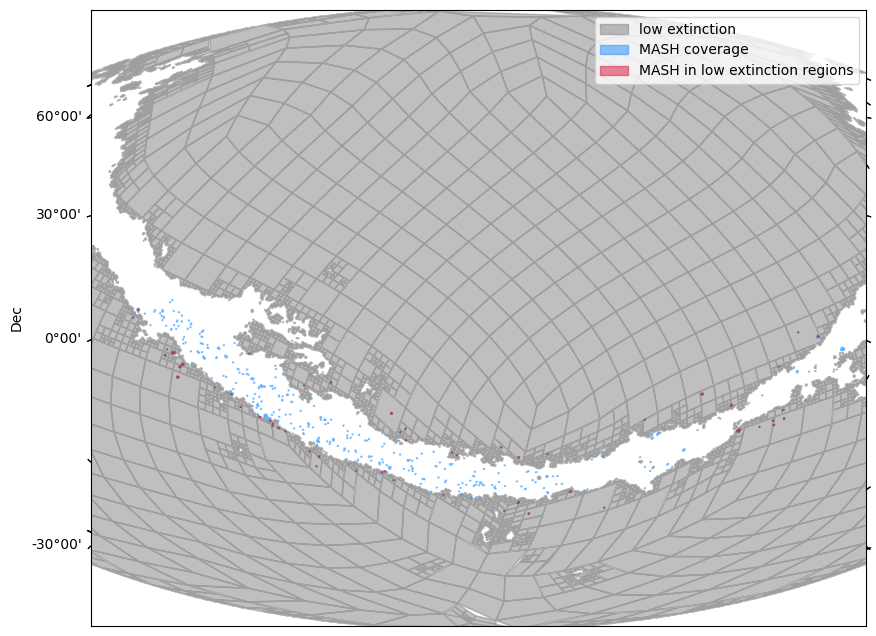

In [23]:
fig = plt.figure(111, figsize=(10, 8))
with mocpy.World2ScreenMPL(
    fig,
    fov=200 * u.deg,
    center=SkyCoord(200, -20, unit="deg", frame="icrs"),
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)
    moc_low_extinction.fill(
        ax=ax, wcs=wcs, alpha=0.5, fill=True, color="grey", label="low extinction"
    )
    moc_mash.fill(
        ax=ax, wcs=wcs, alpha=0.5, fill=True, color="dodgerblue", label="MASH coverage"
    )
    moc_intersection.fill(
        ax=ax,
        wcs=wcs,
        alpha=0.5,
        fill=True,
        color="crimson",
        label="MASH in low extinction regions",
    )
    # Sets labels
    ax.set_xlabel("RA")
    ax.set_ylabel("Dec")
    # Sets ticks
    lon, lat = ax.coords[0], ax.coords[1]
    lon.set_major_formatter("hh:mm:ss")
    lat.set_major_formatter("dd:mm")
    lon.set_ticklabel(exclude_overlapping=True)
    lat.set_ticklabel(exclude_overlapping=True)
    lon.set_ticks(spacing=2 * u.hourangle)
plt.legend()
plt.show()

## Step 5: Query the 2MASS and Gaia Catalogues by MOC

Without the usage of MOC, querying for sources in the low extinction regions covered by the MASH subsample would be tedious or even impossible. Indeed, one would need to load the whole catalog and make selections which would not be possible given the size of some catalogs. Alternatively, one would need to query the catalog field by field, which would take time and several queries. Instead, here we will use the power of MOC files to query large catalogs directly in the covered regions only. We will use coverages of the low extinction and MASH regions to query for sources from the Gaia and 2MASS surveys in these highly non-continuous and non-trivial shape areas.

First, let's see which Gaia and 2MASS catalogs are available on VizieR. We could, as above, use the TAP endpoint of VizieR. But we show below the `Vizier` module in the `astroquery` package.

In [24]:
catalog_list_twomass = Vizier.find_catalogs("Cutri")
for k, v in catalog_list_twomass.items():
    print(k, ": ", v.description)

II/126 :  IRAS Serendipitous Survey Catalog (IPAC 1986)
II/241 :  2MASS Catalog Incremental Data Release (IPAC/UMass, 2000)
II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)
II/281 :  2MASS 6X Point Source Working Database / Catalog (Cutri+ 2006)
II/307 :  WISE Preliminary Data Release (Cutri+ 2011)
II/311 :  WISE All-Sky Data Release (Cutri+ 2012)
II/328 :  AllWISE Data Release (Cutri+ 2013)
II/365 :  The CatWISE2020 catalog (updated version 28-Jan-2021) (Marocco+, 2021)
VII/233 :  The 2MASS Extended sources (IPAC/UMass, 2003-2006)
J/ApJ/560/566 :  K-band galaxy luminosity function from 2MASS (Kochanek+, 2001)
J/ApJ/564/421 :  Spectra of T dwarfs. I. (Burgasser+, 2002)
J/ApJ/569/23 :  Optical polarisation of 2MASS QSOs (Smith+, 2002)
J/ApJ/635/214 :  Chandra X-ray sources and NIR identifications (Ebisawa+, 2005)
J/ApJ/713/330 :  Spitzer observations of major-merger galaxies (Xu+, 2010)
J/ApJ/719/550 :  Deep NIR imaging of {rho} Oph cloud core (Marsh+, 2010)
J/ApJ/741/68 :

In [25]:
catalog_list_gaia = Vizier.find_catalogs("Gaia DR2", max_catalogs=1000)
for k, v in catalog_list_gaia.items():
    print(k, ": ", v.description)

I/345 :  Gaia DR2 (Gaia Collaboration, 2018)
I/347 :  Distances to 1.33 billion stars in Gaia DR2 (Bailer-Jones+, 2018)
I/349 :  StarHorse, Gaia DR2 photo-astrometric distances (Anders+, 2019)
II/360 :  Gaia DR2 x AllWISE catalogue (Marton+, 2019)
IV/35 :  Gaia DR2-WISE Galactic Plane Matches (Wilson+, 2018)
VI/156 :  M-dwarf Lum-Temp-Radius relationships (Morrell+, 2019)
VII/285 :  Gaia DR2 quasar and galaxy classification (Bailer-Jones+, 2019)
J/ApJ/862/138 :  BANYAN. XIII. Nearby young assoc. with Gaia DR2 (Gagne+, 2018)
J/ApJ/863/89 :  Gaia DR2 PMs of stars in ultra-faint MW satellites (Simon, 2018)
J/ApJ/866/99 :  Revised radii of KIC stars & planets using Gaia DR2 (Berger+, 2018)
J/ApJ/867/151 :  YSOs in the Gould Belt regions with Gaia-DR2 data (Dzib+, 2018)
J/ApJ/868/70 :  Hot subdwarf stars from Gaia DR2 and LAMOST DR5 (Lei+, 2018)
J/ApJ/870/32 :  Kinematics in young star clusters & associations (Kuhn+, 2019)
J/ApJ/872/85 :  Detached eclipsing binaries with Gaia parallaxes (Gr

For 2MASS we will want to use `II/246 :  2MASS All-Sky Catalog of Point Sources (Cutri+ 2003)` and for Gaia `I/345 :  Gaia DR2 (Gaia Collaboration, 2018)`. Before we query the full two tables we only look at a few sources for each table to understand which columns are available. The query below will give us 50 sources each -- the default for the `get_catalogs` method.

In [26]:
test_twomass = Vizier.get_catalogs("II/246")
print(test_twomass)
test_twomass[0]

TableList with 1 tables:
	'0:II/246/out' with 15 column(s) and 50 row(s) 


RAJ2000,DEJ2000,_2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8
45.519450,0.880821,03020466+0052509,14.559,0.030,14.312,0.050,14.116,0.048,AAA,222,111,000,0,0
45.529317,0.883630,03020703+0053010,17.136,0.151,17.156,--,17.247,--,CUU,200,100,000,0,0
45.618371,0.835942,03022840+0050093,14.440,0.028,13.695,0.029,13.577,0.038,AAA,222,111,000,0,0
45.617712,0.852819,03022825+0051101,16.342,0.088,15.699,0.085,15.359,0.149,AAB,222,111,000,0,0
45.643064,0.865905,03023433+0051572,11.944,0.027,11.685,0.023,11.609,0.019,AAA,222,111,000,0,0
45.585377,0.848962,03022049+0050562,15.648,0.052,15.008,0.058,14.814,0.084,AAA,222,111,000,0,0
45.589256,0.868881,03022142+0052079,16.658,0.104,15.985,0.137,15.897,0.223,ABD,222,111,000,0,0
45.674810,0.877031,03024195+0052373,15.308,0.045,14.525,0.043,14.261,0.057,AAA,222,111,000,0,0


In [27]:
test_gaia = Vizier.get_catalogs("I/345")
print(test_gaia)
test_gaia[0]

TableList with 20 tables:
	'0:I/345/gaia2' with 32 column(s) and 50 row(s) 
	'1:I/345/rvstdcat' with 32 column(s) and 50 row(s) 
	'2:I/345/rvstdmes' with 7 column(s) and 50 row(s) 
	'3:I/345/allwise' with 2 column(s) and 50 row(s) 
	'4:I/345/iers' with 2 column(s) and 50 row(s) 
	'5:I/345/cepheid' with 25 column(s) and 50 row(s) 
	'6:I/345/rrlyrae' with 23 column(s) and 50 row(s) 
	'7:I/345/lpv' with 13 column(s) and 50 row(s) 
	'8:I/345/varres' with 9 column(s) and 50 row(s) 
	'9:I/345/shortts' with 9 column(s) and 50 row(s) 
	'10:I/345/tsstat' with 13 column(s) and 50 row(s) 
	'11:I/345/numtrans' with 4 column(s) and 50 row(s) 
	'12:I/345/transits' with 20 column(s) and 50 row(s) 
	'13:I/345/rm' with 9 column(s) and 50 row(s) 
	'14:I/345/rmseg' with 16 column(s) and 50 row(s) 
	'15:I/345/rmout' with 2 column(s) and 50 row(s) 
	'16:I/345/ssoobj' with 6 column(s) and 50 row(s) 
	'17:I/345/ssoorb' with 19 column(s) and 50 row(s) 
	'18:I/345/ssores' with 10 column(s) and 50 row(s) 
	'19:

RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
45.09385125633,0.5468,0.64718689957,0.5908,59236189231232,0.6518,0.6371,0.314,1.301,-0.696,1.185,0,216,1.702,19.8521,0.0086,139.7,26.32,19.9881,0.2045,180.2,9.54,19.1227,0.0575,0.8654,--,--,--,--,--,--,--
45.09016634680,0.1233,0.64778425962,0.1282,59236189231360,3.3237,0.1433,30.321,0.268,11.596,0.258,0,1668,2.888,17.6330,0.0019,334,12.01,19.0420,0.0390,2092,11.22,16.4604,0.0058,2.5817,--,--,--,--,--,--,--
45.09637402450,0.1503,0.65057829283,0.1729,59270548970752,0.1847,0.1751,3.537,0.324,0.654,0.329,0,1152,2.626,18.0343,0.0025,578.5,8.796,18.4457,0.0165,812.5,10.04,17.4873,0.0134,0.9584,--,--,--,--,--,--,--
45.10917067997,0.0508,0.65253074863,0.0511,59270548971648,3.0466,0.0589,-9.468,0.112,-42.970,0.108,0,8026,7.941,15.9271,0.0011,2279,19.84,16.9569,0.0094,8598,28.17,14.9259,0.0036,2.0310,--,--,3968.25,0.5188,0.2743,0.51,0.058
45.09796814525,0.1832,0.65754124036,0.2085,59270548972672,2.4526,0.2132,-5.853,0.398,-16.305,0.397,0,916.7,2.068,18.2828,0.0024,192.4,21.36,19.6409,0.1205,1180,9.902,17.0824,0.0091,2.5585,--,--,--,--,--,--,--
45.19007365441,0.1721,0.61029286301,0.1585,59407987910400,0.5127,0.2013,4.836,0.396,-7.668,0.343,0,796.5,2.06,18.4355,0.0028,316.2,12.3,19.1014,0.0422,697.3,19.29,17.6534,0.0300,1.4480,--,--,--,--,--,--,--
45.17954669668,0.0417,0.62334168746,0.0374,59481002873984,0.3591,0.0483,5.397,0.090,-2.072,0.079,0,1.06e+04,7.983,15.6254,0.0008,5177,21.25,16.0661,0.0045,7884,16.63,15.0201,0.0023,1.0461,--,--,5230.15,--,--,2.26,3.434
45.19835624575,0.7170,0.61889600019,0.6358,59511067349888,1.2027,0.8248,18.321,1.612,-5.007,1.486,0,158.9,1.178,20.1853,0.0080,32.06,9.529,21.5865,0.3227,194.4,14.25,19.0402,0.0796,2.5463,--,--,--,--,--,--,--


As you will see below, we only need coordinates, 2MASS photometry in the H and K band, and Gaia photometry in the Gaia G band. So we'll query the tables `II/246/out` for 2MASS and `I/345/gaia2` for Gaia DR2:

In [28]:
twomass = moc_intersection.query_vizier_table("II/246/out", max_rows=20000)
twomass

_2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
,deg,deg,arcsec,arcsec,deg,mag,mag,mag,mag,mag,mag,,,,d
str17,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,str3,int16,uint8,float64
07004924-2609161,105.205199,-26.154478,0.06,0.06,90.0,12.241,11.679,11.401,0.027,0.026,0.023,AAA,222,0,2451208.5657
07005553-2609080,105.231379,-26.152241,0.07,0.07,45.0,15.443,14.916,14.773,0.033,0.049,0.109,AAB,222,0,2451208.5657
07005410-2608455,105.225439,-26.145973,0.06,0.06,90.0,10.554,10.259,10.203,0.024,0.024,0.019,AAA,222,0,2451208.5657
07005605-2608553,105.233576,-26.14872,0.06,0.06,90.0,11.891,11.6,11.596,0.026,0.024,0.023,AAA,222,0,2451208.5657
07005809-2608512,105.242043,-26.147581,0.21,0.2,109.0,16.746,16.293,15.534,0.138,0.199,--,BCU,220,0,2451208.5657
07005247-2609231,105.218641,-26.156427,0.08,0.08,135.0,15.602,15.26,15.049,0.063,0.077,0.147,AAB,222,0,2451208.5657
07005211-2609189,105.217137,-26.155258,0.06,0.06,90.0,14.179,13.935,13.901,0.041,0.043,0.065,AAA,222,0,2451208.5657
07005137-2609029,105.214075,-26.150816,0.19,0.19,45.0,16.608,16.15,16.086,0.131,0.17,--,BCU,220,0,2451208.5657


In [29]:
gaia = moc_intersection.query_vizier_table("I/345/gaia2", max_rows=20000)
gaia

ra_epoch2000,dec_epoch2000,errHalfMaj,errHalfMin,errPosAng,source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,bp_rp,radial_velocity,radial_velocity_error,rv_nb_transits,teff_val,a_g_val,e_bp_min_rp_val,radius_val,lum_val
deg,deg,arcsec,arcsec,deg,,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,e-/s,e-/s,mag,e-/s,e-/s,mag,e-/s,e-/s,mag,mag,km / s,km / s,,K,mag,mag,Rsun,Lsun
float64,float64,float32,float32,float32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float32,float32,float64,float64
105.2066061184302,-26.1538940663577,0.004,0.004,0.0,2920762586611045376,105.20658290054,0.1161,-26.15393087599,0.149,0.136,0.1944,-4.84,0.253,-8.549,0.271,False,602.539,1.1074,18.738403,267.377,5.59862,19.283577,535.627,6.13289,17.939764,1.343813,--,--,0,--,--,--,--,--
105.2052022499317,-26.1544492445426,0.001,0.001,0.0,2920762586615338752,105.20527986473,0.0267,-26.15425317585,0.0358,15.1333,0.0454,16.181,0.059,45.539,0.066,False,16217.1,8.55749,15.163431,2736.6,12.0165,16.75836,21463.4,32.9159,13.932673,2.825687,--,--,0,3928.82,0.1227,0.094,--,--
105.2254316259827,-26.1459685548036,0.001,0.001,0.0,2920762724054281728,105.22540767106,0.0161,-26.14597192505,0.0217,3.0363,0.0265,-4.994,0.034,-0.783,0.039,False,447474.0,150.212,11.561445,240915.0,221.395,11.896729,295385.0,244.062,11.085948,0.810782,12.24,0.54,10,5789.0,0.359,0.195,1.38,1.916
105.2255476000922,-26.1406471806866,0.062,0.038,90.0,2920762724052466816,105.22555538166,2.0243,-26.14064454062,1.4671,-4.0178,1.6818,1.622,3.991,0.613,2.468,False,76.608,1.20685,20.97768,36.0788,7.86989,21.458258,65.0345,7.80032,20.229061,1.229197,--,--,0,--,--,--,--,--
105.2186311670325,-26.156438621226,0.002,0.001,0.0,2920762685395330944,105.21862542833,0.0384,-26.1564233977,0.0518,0.4535,0.0652,-1.196,0.088,3.536,0.101,False,3596.37,2.41419,16.798706,1782.51,6.52961,17.223808,2630.98,10.0304,16.211626,1.012182,--,--,0,5324.0,0.2803,0.14,--,--
105.2119407930607,-26.148242191244,0.012,0.011,0.0,2920762689690245120,105.21193444979,0.3448,-26.14822964561,0.433,0.6099,0.6059,-1.322,0.699,2.914,0.795,False,151.185,0.741582,20.239592,58.4888,5.62295,20.933706,147.958,5.41634,19.336573,1.597134,--,--,0,--,--,--,--,--
105.2101027197529,-26.1493188643026,0.003,0.002,0.0,2920762685393857664,105.21008829533,0.075,-26.14929289497,0.1004,0.5265,0.1263,-3.007,0.157,6.032,0.181,False,1089.74,1.25074,18.09506,474.512,8.77005,18.66077,951.979,11.217,17.315351,1.345419,--,--,0,--,--,--,--,--
105.233577941629,-26.1487114377012,0.001,0.001,0.0,2920762655334900352,105.23358687293,0.0188,-26.14871224799,0.0281,0.6511,0.0338,1.862,0.039,-0.188,0.05,False,141155.0,27.6249,12.814123,79733.0,74.3211,13.097294,90552.3,113.271,12.369671,0.727623,--,--,0,6290.0,--,--,3.03,12.909


## Step 6: Cross-match Gaia and WISE sources in all fields

We now want to find sources in the selected region (observed in the MASH regions of interest and at low extinction) that are common to the Wide Infrared Survey Explorer ([WISE](https://irsa.ipac.caltech.edu/Missions/wise.html)) and Gaia catalogs. To do so, we will perform a cross-match of the Gaia and WISE catalogs. Alternatively, we could use the CDS XMatch service via the corresponding `astroquery` module.

To do so, let's first inspect the `match_coordinates_sky` function from `astropy.coordinates`. 

In [30]:
help(match_coordinates_sky)

Help on function match_coordinates_sky in module astropy.coordinates.matching:

match_coordinates_sky(matchcoord, catalogcoord, nthneighbor=1, storekdtree='kdtree_sky')
    Finds the nearest on-sky matches of a coordinate or coordinates in
    a set of catalog coordinates.
    
    This finds the on-sky closest neighbor, which is only different from the
    3-dimensional match if ``distance`` is set in either ``matchcoord``
    or ``catalogcoord``.
    
    Parameters
    ----------
    matchcoord : `~astropy.coordinates.BaseCoordinateFrame` or `~astropy.coordinates.SkyCoord`
        The coordinate(s) to match to the catalog.
    catalogcoord : `~astropy.coordinates.BaseCoordinateFrame` or `~astropy.coordinates.SkyCoord`
        The base catalog in which to search for matches. Typically this will
        be a coordinate object that is an array (i.e.,
        ``catalogcoord.isscalar == False``)
    nthneighbor : int, optional
        Which closest neighbor to search for.  Typically ``1`

In [31]:
# We generate the coordinates in the appropriate format
twomass_coord = SkyCoord(ra=twomass["RAJ2000"], dec=twomass["DEJ2000"], unit=u.deg)
gaia_coord = SkyCoord(ra=gaia["ra_epoch2000"], dec=gaia["dec_epoch2000"], unit=u.deg)

index, separation_2d, _ = match_coordinates_sky(twomass_coord, gaia_coord)

In [32]:
# Decide the maximum separation between objects to be considered acceptable matches
max_separation = 1.0 * u.arcsec
# Apply constraint on the two catalogs
sep_constraint = separation_2d < max_separation
twomass_matches = twomass[sep_constraint]
gaia_matches = gaia[index[sep_constraint]]
# Select only interesting columns from twomass_matches
match_catalog = twomass_matches["_2MASS", "RAJ2000", "DEJ2000", "Hmag", "Kmag"]
# Add column G magnitude from gaia
match_catalog["Gmag"] = gaia_matches["phot_g_mean_mag"]
match_catalog

_2MASS,RAJ2000,DEJ2000,Hmag,Kmag,Gmag
,deg,deg,mag,mag,mag
str17,float64,float64,float32,float32,float64
07004924-2609161,105.205199,-26.154478,11.679,11.401,15.163431
07005553-2609080,105.231379,-26.152241,14.916,14.773,17.04277
07005410-2608455,105.225439,-26.145973,10.259,10.203,11.561445
07005605-2608553,105.233576,-26.14872,11.6,11.596,12.814123
07005809-2608512,105.242043,-26.147581,16.293,15.534,18.124905
07005247-2609231,105.218641,-26.156427,15.26,15.049,16.798706
07005211-2609189,105.217137,-26.155258,13.935,13.901,15.073216
07005137-2609029,105.214075,-26.150816,16.15,16.086,18.203348


## Step 7: Build a color-color diagram

We now use the data we got from the cross-match to get a WISE/Gaia color-color diagram for all the sources in the low extinction sky regions covered by the MASH survey:

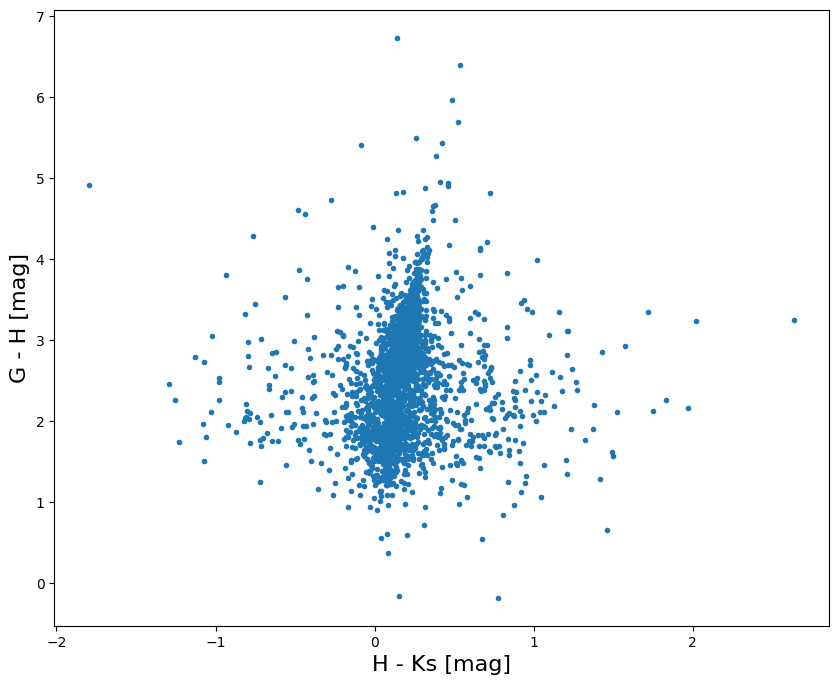

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(
    match_catalog["Hmag"] - match_catalog["Kmag"],
    match_catalog["Gmag"] - match_catalog["Hmag"],
    linestyle="",
    marker=".",
)
ax.set_xlabel("H - Ks [mag]", fontsize=16)
ax.set_ylabel("G - H [mag]", fontsize=16)
plt.show()